In [45]:
import pandas as pd
import numpy as np
import ast
from geopy.distance import geodesic
import polyline
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import copy

In [118]:
df = pd.read_csv('/home/smebellis/ece5831_final_project/processed_data/post_processing_clustered.csv') 
sampled_df = df.sample(n=1000, random_state=42)

In [119]:
df["DURATION_2"] = df['POLYLINE'].apply(lambda polyline: (len(polyline) - 1) * 15)
df['DURATION'] = df['POLYLINE'].apply(lambda x: 15 * len(x))

In [120]:
df

,TRIP_ID,CALL_TYPE,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,TRAVEL_TIME,POLYLINE_LIST,START,...,Destination_Cluster,Destination_DOM,DISTRIC_CLUSTER,TIME_CLUSTER,TIME_PERIODS,CLUSTER,DOM,TRAFFIC_STATUS,DURATION_2,DURATION
0,1372982532620000005,B,20000005,2013-07-05 00:02:12,A,False,"[[-8.617599,41.14611],[-8.617572,41.145912],[-...",8715,"[[-8.617599, 41.14611], [-8.617572, 41.145912]...","[-8.617599, 41.14611]",...,-1.0,0.000000,Cluster 5,1,Morning,-1.0,0.230508,Light,8715,8730
1,1372982432620000574,C,20000574,2013-07-05 00:00:32,A,False,"[[-8.610219,41.140953],[-8.610246,41.140962],[...",8220,"[[-8.610219, 41.140953], [-8.610246, 41.140962...","[-8.610219, 41.140953]",...,-1.0,0.000000,Cluster 5,1,Morning,0.0,0.000000,Light,8220,8235
2,1372982559620000297,B,20000297,2013-07-05 00:02:39,A,False,"[[-8.615538,41.140656],[-8.614809,41.140962],[...",8805,"[[-8.615538, 41.140656], [-8.614809, 41.140962...","[-8.615538, 41.140656]",...,-1.0,0.000000,Cluster 5,1,Morning,0.0,0.000000,Light,8805,8820
3,1372982582620000611,C,20000611,2013-07-05 00:03:02,A,False,"[[-8.613666,41.148378],[-8.614494,41.148108],[...",8130,"[[-8.613666, 41.148378], [-8.614494, 41.148108...","[-8.613666, 41.148378]",...,108.0,0.449195,Cluster 5,1,Morning,1.0,0.000000,Light,8130,8145
4,1372983070620000406,C,20000406,2013-07-05 00:11:10,A,False,"[[-8.626626,41.153949],[-8.627418,41.155524],[...",2625,"[[-8.626626, 41.153949], [-8.627418, 41.155524...","[-8.626626, 41.153949]",...,95.0,1.000000,Cluster 1,1,Morning,-1.0,0.990875,Heavy,2625,2640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1704754,1403738283620000321,B,20000321,2014-06-25 23:18:03,A,False,"[[-8.619867,41.148072],[-8.620299,41.147694],[...",13095,"[[-8.619867, 41.148072], [-8.620299, 41.147694...","[-8.619867, 41.148072]",...,-1.0,0.000000,Cluster 5,0,Night,-1.0,0.167135,Light,13095,13110
1704755,1403739509620000045,A,20000045,2014-06-25 23:38:29,A,False,"[[-8.594361,41.169384],[-8.594415,41.169411],[...",10680,"[[-8.594361, 41.169384], [-8.594415, 41.169411...","[-8.594361, 41.169384]",...,66.0,0.153051,Cluster 1,0,Night,0.0,0.595499,Medium,10680,10695
1704756,1403737389620000456,C,20000456,2014-06-25 23:03:09,A,False,"[[-8.609994,41.140899],[-8.610048,41.140926],[...",12090,"[[-8.609994, 41.140899], [-8.610048, 41.140926...","[-8.609994, 41.140899]",...,111.0,1.000000,Cluster 5,0,Night,0.0,0.385364,Light,12090,12105
1704757,1403738938620000506,C,20000506,2014-06-25 23:28:58,A,False,"[[-8.626995,41.152455],[-8.627022,41.152455],[...",7875,"[[-8.626995, 41.152455], [-8.627022, 41.152455...","[-8.626995, 41.152455]",...,59.0,0.711636,Cluster 5,0,Night,0.0,0.967686,Heavy,7875,7890


: 

In [35]:
def convert_coordinates(string):
    """
    Loads list of coordinates from given string and swap out longitudes & latitudes.
    We do the swapping because the standard is to have latitude values first, but
    the original datasets provided in the competition have it backwards.
    """
    return [(lat, long) for (long, lat) in json.loads(string)]

In [112]:
def extract_features(df):
    """
    Extract some features from the original columns in the given dataset.
    """
    # Convert polyline values from strings to list objects
    df['POLYLINE'] = df['POLYLINE'].apply(convert_coordinates)
    # Extract start latitudes and longitudes
    df['START_LAT'] = df['POLYLINE'].apply(lambda x: x[0][0])
    df['START_LONG'] = df['POLYLINE'].apply(lambda x: x[0][1])
    df['END_LAT'] = df['POLYLINE'].apply(lambda x: x[-1][0])
    df['END_LONG'] = df['POLYLINE'].apply(lambda x: x[-1][1])
  
    df["DURATION_2"] = df['POLYLINE'].apply(lambda polyline: (len(polyline) - 1) * 15)
    df['DURATION'] = df['POLYLINE'].apply(lambda x: 15 * len(x))
    
    return df

In [113]:
# Coordinates of Porto's city centre
porto = [41.1579, -8.6291]
df = extract_features(df)

In [46]:
def density_map(latitudes, longitudes, center=porto, bins=1000, radius=0.1):
    """
    Displays a density map in a matplotlib histogram for all the points
    defined by the given latitudes and longitudes.
    """
    # LogNorm will flag 0-value pixels as "bad" and color them in white.
    # So we tweak the color map to color them in black.
    cmap = copy.copy(plt.cm.jet)
    cmap.set_bad((0,0,0))  # Fill background with black

    # Center the map around the provided center coordinates
    histogram_range = [
        [center[1] - radius, center[1] + radius],
        [center[0] - radius, center[0] + radius]
    ]
    
    plt.figure(figsize=(5,5))
    plt.hist2d(longitudes, latitudes, bins=bins, norm=LogNorm(),
               cmap=cmap, range=histogram_range)

    # Remove all axes and annotations to keep the map clean and simple
    plt.grid('off')
    plt.axis('off')
    plt.gca().xaxis.set_visible(False)
    plt.gca().yaxis.set_visible(False)
    plt.tight_layout()
    plt.show()

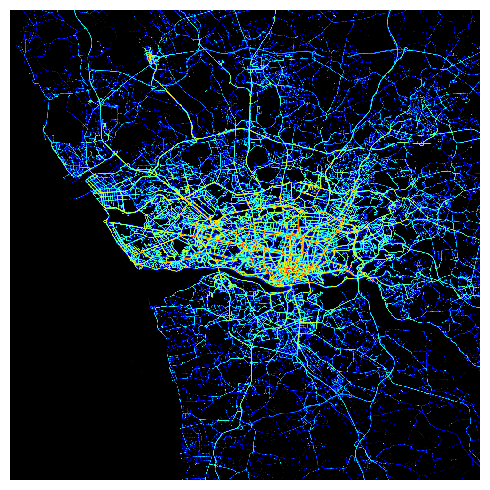

In [114]:
all_coords = np.concatenate(df['POLYLINE'].to_numpy())
density_map(all_coords[:,0], all_coords[:,1])

In [54]:
import math
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # Radius of Earth in kilometers (use 3956 for miles)
    radius = 6371.0
    distance = radius * c

    return distance

In [58]:
lat1, long1, lat2, long2 = df['START_LAT'], df['START_LONG'], df['END_LAT'], df['END_LONG']

In [102]:
distance = haversine_distance(lat1[1], long1[1], lat2[1], long2[1])
print(f"Distance: {distance:.2f} km")

Distance: 3.21 km


In [104]:
duration = df['DURATION'][1]

In [107]:
duration = duration /3600

In [62]:
def average_speed(distance, duration):
    # distance in km, duration in hours
    return distance / duration

In [108]:
speed = average_speed(distance, duration)
print(f"SPEED: {speed}")

SPEED: 30.86360479288053


In [79]:
def encode_hour(hour):
    period = 24
    hour_rad = 2 * np.pi * hour / period
    sin_hour = np.sin(hour_rad)
    cos_hour = np.cos(hour_rad)
    return sin_hour, cos_hour



In [103]:
lat1[1], long1[1], lat2[1], long2[1]

(41.140953, -8.610219, 41.148603, -8.647245)

In [115]:
df

,TRIP_ID,CALL_TYPE,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,TRAVEL_TIME,POLYLINE_LIST,START,...,DISTRIC_CLUSTER,TIME_CLUSTER,TIME_PERIODS,CLUSTER,DOM,TRAFFIC_STATUS,START_LAT,START_LONG,DURATION_2,DURATION
0,1372982532620000005,B,20000005,2013-07-05 00:02:12,A,False,"[(41.14611, -8.617599), (41.145912, -8.617572)...",8715,"[[-8.617599, 41.14611], [-8.617572, 41.145912]...","[-8.617599, 41.14611]",...,Cluster 5,1,Morning,-1.0,0.230508,Light,41.146110,-8.617599,390,405
1,1372982432620000574,C,20000574,2013-07-05 00:00:32,A,False,"[(41.140953, -8.610219), (41.140962, -8.610246...",8220,"[[-8.610219, 41.140953], [-8.610246, 41.140962...","[-8.610219, 41.140953]",...,Cluster 5,1,Morning,0.0,0.000000,Light,41.140953,-8.610219,360,375
2,1372982559620000297,B,20000297,2013-07-05 00:02:39,A,False,"[(41.140656, -8.615538), (41.140962, -8.614809...",8805,"[[-8.615538, 41.140656], [-8.614809, 41.140962...","[-8.615538, 41.140656]",...,Cluster 5,1,Morning,0.0,0.000000,Light,41.140656,-8.615538,390,405
3,1372982582620000611,C,20000611,2013-07-05 00:03:02,A,False,"[(41.148378, -8.613666), (41.148108, -8.614494...",8130,"[[-8.613666, 41.148378], [-8.614494, 41.148108...","[-8.613666, 41.148378]",...,Cluster 5,1,Morning,1.0,0.000000,Light,41.148378,-8.613666,360,375
4,1372983070620000406,C,20000406,2013-07-05 00:11:10,A,False,"[(41.153949, -8.626626), (41.155524, -8.627418...",2625,"[[-8.626626, 41.153949], [-8.627418, 41.155524...","[-8.626626, 41.153949]",...,Cluster 1,1,Morning,-1.0,0.990875,Heavy,41.153949,-8.626626,105,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1704754,1403738283620000321,B,20000321,2014-06-25 23:18:03,A,False,"[(41.148072, -8.619867), (41.147694, -8.620299...",13095,"[[-8.619867, 41.148072], [-8.620299, 41.147694...","[-8.619867, 41.148072]",...,Cluster 5,0,Night,-1.0,0.167135,Light,41.148072,-8.619867,585,600
1704755,1403739509620000045,A,20000045,2014-06-25 23:38:29,A,False,"[(41.169384, -8.594361), (41.169411, -8.594415...",10680,"[[-8.594361, 41.169384], [-8.594415, 41.169411...","[-8.594361, 41.169384]",...,Cluster 1,0,Night,0.0,0.595499,Medium,41.169384,-8.594361,480,495
1704756,1403737389620000456,C,20000456,2014-06-25 23:03:09,A,False,"[(41.140899, -8.609994), (41.140926, -8.610048...",12090,"[[-8.609994, 41.140899], [-8.610048, 41.140926...","[-8.609994, 41.140899]",...,Cluster 5,0,Night,0.0,0.385364,Light,41.140899,-8.609994,540,555
1704757,1403738938620000506,C,20000506,2014-06-25 23:28:58,A,False,"[(41.152455, -8.626995), (41.152455, -8.627022...",7875,"[[-8.626995, 41.152455], [-8.627022, 41.152455...","[-8.626995, 41.152455]",...,Cluster 5,0,Night,0.0,0.967686,Heavy,41.152455,-8.626995,345,360


In [116]:
len(df['POLYLINE'])

1704759

In [117]:
len(df['POLYLINE_LIST'])

1704759